In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [482]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Clifford\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Clifford\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Clifford\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Clifford\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [379]:
cs = pd.read_excel("CyberSecuritySpecialist.xlsx", sheet_name = 0)
da = pd.read_excel("DataAnalyst.xlsx", sheet_name = 0)
se = pd.read_excel("SoftwareEngineer.xlsx", sheet_name = 0)

cs["Role"] = "Cyber Security Specialist"
da["Role"] = "Data Analyst"
se["Role"] = "Software Engineer"

In [380]:
print(cs.shape, da.shape, se.shape, sep = "\n")

(123, 12)
(122, 12)
(125, 12)


In [381]:
data = pd.concat([cs, da, se], axis = 0, ignore_index = True)
data.shape

(370, 12)

In [382]:
data = data.drop_duplicates().reset_index()
data.shape
# 22 duplicated jobs

(369, 13)

Cyber Security Specialist


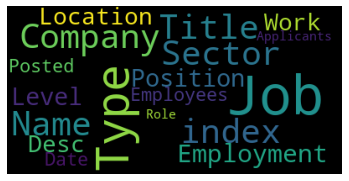

Data Analyst


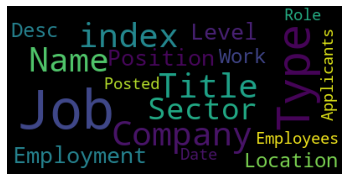

Software Engineer


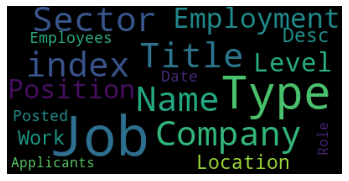

In [383]:
from functools import reduce

stop_words = stopwords.words("english")
for role in data["Role"].unique():
    subset = data[data["Role"] == role]
    all_descriptions = reduce(lambda x, y: " ".join([x, y]), subset)
    tokenized = word_tokenize(all_descriptions)

    wordcloud = WordCloud(stopwords = stop_words).generate(all_descriptions)
    print(role)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


In [535]:
stop_words = stopwords.words("english")
stop_words.extend([
    "business", "data", "skills", "skill", 
    "team", "opportunity", "work", "experience",
    "job", "status", "applicants", "previous"
])

def clean_desc(desc):
    cleaned = []
    for sentence in desc.split("\n"):
        if not sentence.strip(" "):
            continue

        no_unicode = re.sub(r"[^\x00-\x7F]+", "", sentence)
        no_punctuation = re.sub("[^\w\s]", " ", no_unicode)
        no_digits = re.sub("\d+", "", no_punctuation)
        tokenized = word_tokenize(no_digits)

        tagged = nltk.pos_tag(tokenized)
        skills = []
        for tag, pos in tagged:
            if pos not in ["NN", "NNS", "NNP", "JJ"]:
                continue
            if tag.lower() in stop_words:
                continue

            skills.append(tag)
        cleaned.extend(skills)

    return " ".join(cleaned)

cleaned_desc = data["Job Desc"].apply(clean_desc)

In [536]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

def run_randomforest(features, target, ngram = (1, 1)):
    vectorizer = TfidfVectorizer(ngram_range = ngram)
    vectorized = vectorizer.fit_transform(features)
    feature_names = vectorizer.get_feature_names_out()

    rf = RandomForestClassifier()
    rf.fit(vectorized, target)
    
    return pd.Series(rf.feature_importances_, index = feature_names).sort_values(ascending = False)


def run_naivebayes(features, target, ngram = (2, 2)):
    vectorizer = TfidfVectorizer(ngram_range = ngram)
    vectorized = vectorizer.fit_transform(features)
    feature_names = vectorizer.get_feature_names_out()

    nb = MultinomialNB()
    nb.fit(vectorized, target)
    
    return [pd.Series(feature_prob, index = feature_names) for feature_prob in nb.feature_log_prob_]

rf_results = run_randomforest(cleaned_desc, data["Role"], (2, 2))
nb_results = run_naivebayes(cleaned_desc, data["Role"], (2, 2))

In [537]:
nb_results[0].nlargest(20)

cyber security              -9.114546
incident response           -9.309093
information security        -9.388828
risk management            -10.035439
policies standards         -10.036080
smart nation               -10.064859
network security           -10.099764
computer science           -10.104514
security policies          -10.122004
financial services         -10.138076
internal external          -10.142420
vulnerability assessment   -10.143616
security operations        -10.144534
security information       -10.153410
policies procedures        -10.193613
security incident          -10.201712
content creators           -10.202501
public figures             -10.202501
citizens businesses        -10.217978
covid vaccination          -10.224162
dtype: float64

In [546]:
data.drop(data[(data == "Nil").any(axis = 1)].index)

,index,Job Title,Company Name,Sector,Employment Type,Position Level,Location,Work Type,Job Desc,No. of Employees,Job Posted Date,Applicants,Role
0,0,Risk | Risk & Modelling Services (Risk) Associ...,PwC Singapore,Accounting,Full-time,Associate,"Singapore, Singapore",On-site,\n\n\n \nLine of Service\nAdvisory\nIndustry/S...,"1,001-5,000 employees",4 days ago,2 applicants,Cyber Security Specialist
3,3,Clearing Specialist,Bitget,Financial Services,Full-time,Associate,"Singapore, Singapore",On-site,\n\n\n \nThe ideal candidate will be responsib...,201-500 employees,4 days ago,14 applicants,Cyber Security Specialist
6,6,Signal Analyst (Underwater Sensors),DSO National Laboratories,Defense and Space Manufacturing,Full-time,Mid-Senior level,"Singapore, Singapore",On-site,\n\n\n \nDSO National Laboratories (DSO) is Si...,"1,001-5,000 employees",1 day ago,3 applicants,Cyber Security Specialist
7,7,Data Quality Lead,Michael Page,Staffing and Recruiting,Full-time,Associate,"Singapore, Singapore",On-site,\n\n\n \nOur client is a leading international...,"5,001-10,000 employees",3 days ago,8 applicants,Cyber Security Specialist
8,8,Programme Manager (Cybersecurity Capability Ce...,GovTech Singapore,IT Services and IT Consulting,Full-time,Mid-Senior level,"Singapore, Singapore",Hybrid,\n\n\n \n The Government Techno...,"1,001-5,000 employees",3 days ago,1 applicant,Cyber Security Specialist
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,361,Senior Developer Lead,Standard Chartered Bank,Banking,Full-time,Mid-Senior level,"Singapore, Singapore",On-site,\n\n\n \n\nAbout Standard Chartered \nWe're an...,"10,001+ employees",3 days ago,27 applicants,Software Engineer
365,366,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Crossover for Work,IT Services and IT Consulting,Full-time,Associate,"Singapore, Singapore",Remote,\n\n\n \n Crossover is the worl...,"1,001-5,000 employees",22 hours ago,86 applicants,Software Engineer
366,367,React Developer,Volt - International,Staffing and Recruiting,Full-time,Entry level,"Singapore, Singapore",On-site,\n\n\n \nReact Developer - 2-year contract - S...,51-200 employees,3 days ago,31 applicants,Software Engineer
367,368,Analyst or Senior Analyst- Customer Experience...,Agoda,"Technology, Information and Internet",Full-time,Associate,"Singapore, Singapore",Hybrid,\n\n\n \nAbout Agoda\nAgoda is an online trave...,"5,001-10,000 employees",19 hours ago,1 applicant,Software Engineer
